In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timezone
from pathlib import Path
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler

DATA_DIR = Path('..') / 'data'

In [124]:
# Importamos los datos e imprimimos una muestra

fraud_train = pd.read_csv("data\\fraudTrain.csv", index_col='Unnamed: 0')

fraud_test = pd.read_csv("data\\fraudTest.csv", index_col='Unnamed: 0')

fraud_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [125]:
# Imprimimos la información del dataset
fraud_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [126]:
# Comprobamos si hay valores duplicados en el dataset

duplicates = fraud_train.duplicated()
if duplicates.any():
    print("Hay valores duplicados en el dataset")
else:
    print("No hay valores duplicados en el dataset")

No hay valores duplicados en el dataset


In [127]:
fraud_processed = fraud_train.copy()

In [128]:
# Las columna trans_date_trans_time indica la fecha de la transaccion, 

fraud_processed.drop(columns=['cc_num', 'first', 'last', 'street', 'trans_num', 'zip'], inplace=True)

In [129]:
fraud_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   city                   1296675 non-null  object 
 6   state                  1296675 non-null  object 
 7   lat                    1296675 non-null  float64
 8   long                   1296675 non-null  float64
 9   city_pop               1296675 non-null  int64  
 10  job                    1296675 non-null  object 
 11  dob                    1296675 non-null  object 
 12  unix_time              1296675 non-null  int64  
 13  merch_lat              1296675 non-null  float64
 14  merch_long             

In [130]:
fraud_processed["unix_time"] = fraud_processed["unix_time"].apply(
    lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S"))

In [131]:
fraud_processed.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,2012-01-01 00:00:18,36.011293,-82.048315,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,2012-01-01 00:00:44,49.159047,-118.186462,0
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,2012-01-01 00:00:51,43.150704,-112.154481,0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,1967-01-12,2012-01-01 00:01:16,47.034331,-112.561071,0
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,2012-01-01 00:03:06,38.674999,-78.632459,0


La columna `unix_time` contiene la misma información que la columna `trans_date_trans_time` pero con el año erróneo, ya que los datos empiezan en el 1 de enero de 2019 mientras que la columna `unix_time` empieza en el año 2012.

In [132]:
fraud_processed['trans_date_trans_time'] = pd.to_datetime(fraud_processed['trans_date_trans_time'])

fraud_processed['trans_date'] = fraud_processed['trans_date_trans_time'].dt.date
fraud_processed['trans_time'] = fraud_processed['trans_date_trans_time'].dt.time

fraud_processed['hour'] = fraud_processed['trans_time'].apply(lambda x: x.hour)
fraud_processed['day'] = fraud_processed['trans_date'].apply(lambda x: x.day)

fraud_processed.drop(columns=['unix_time', 'trans_date_trans_time'], inplace=True)

In [133]:
fraud_processed.head()

,merchant,category,amt,gender,city,state,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,trans_date,trans_time,hour,day
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,2019-01-01,00:00:18,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,2019-01-01,00:00:44,0,1
2,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,2019-01-01,00:00:51,0,1
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,2019-01-01,00:01:16,0,1
4,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,2019-01-01,00:03:06,0,1


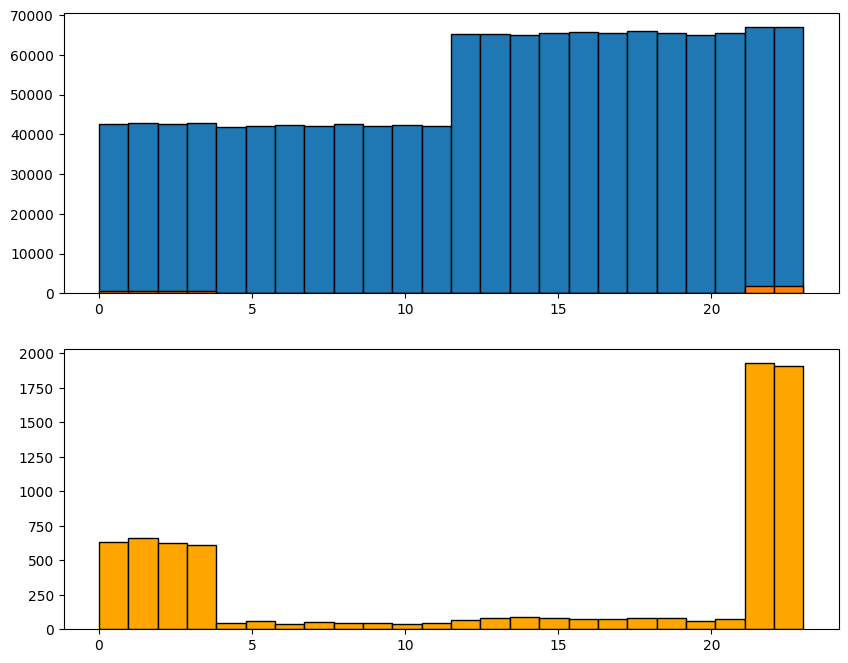

In [134]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].hist(fraud_processed['hour'], bins=24, edgecolor='black')

ax[0].hist(fraud_processed[fraud_processed['is_fraud'] == 1]['hour'], bins=24, edgecolor='black')
ax[1].hist(fraud_processed[fraud_processed['is_fraud'] == 1]['hour'], bins=24, edgecolor='black', color='orange');

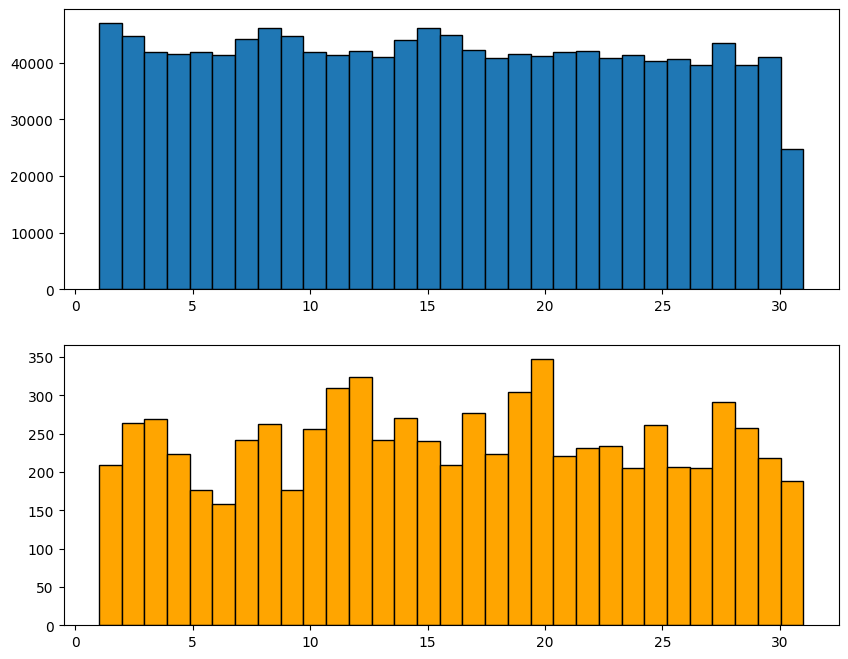

In [135]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].hist(fraud_processed['day'], bins=31, edgecolor='black')
ax[1].hist(fraud_processed[fraud_processed['is_fraud'] == 1]['day'], bins=31, edgecolor='black', color='orange');


#### NPL A LA COLUMNA JOBS
Vamos a explorar la columna job para ver que conclusiones podemos sacar de ella

In [136]:
fraud_train["job"]

0                  Psychologist, counselling
1          Special educational needs teacher
2                Nature conservation officer
3                            Patent attorney
4             Dance movement psychotherapist
                         ...                
1296670                         Geoscientist
1296671     Production assistant, television
1296672                      Naval architect
1296673                Volunteer coordinator
1296674             Therapist, horticultural
Name: job, Length: 1296675, dtype: object

Vemos que tiene una cantidad de unicos considerable, y que cada trabajo suele tener indicadas dos palabras o más por lo que agruparlos puede que no sea tan sencillo

In [137]:
len(fraud_train["job"].unique())

494

In [138]:
fraud_train["job"].unique()

array(['Psychologist, counselling', 'Special educational needs teacher',
       'Nature conservation officer', 'Patent attorney',
       'Dance movement psychotherapist', 'Transport planner',
       'Arboriculturist', 'Designer, multimedia',
       'Public affairs consultant', 'Pathologist', 'IT trainer',
       'Systems developer', 'Engineer, land', 'Systems analyst',
       'Naval architect', 'Radiographer, diagnostic',
       'Programme researcher, broadcasting/film/video', 'Energy engineer',
       'Event organiser', 'Operational researcher', 'Market researcher',
       'Probation officer', 'Leisure centre manager',
       'Corporate investment banker', 'Therapist, occupational',
       'Call centre manager', 'Police officer',
       'Education officer, museum', 'Physiotherapist', 'Network engineer',
       'Forensic psychologist', 'Geochemist',
       'Armed forces training and education officer',
       'Designer, furniture', 'Optician, dispensing',
       'Psychologist, forensic

Tiene trabajos que son muy repetidos, por lo que es muy probable que siempre se hayan registado de la misma forma

In [139]:
fraud_train["job"].value_counts().head(50)

job
Film/video editor                                    9779
Exhibition designer                                  9199
Naval architect                                      8684
Surveyor, land/geomatics                             8680
Materials engineer                                   8270
Designer, ceramics/pottery                           8225
Systems developer                                    7700
IT trainer                                           7679
Financial adviser                                    7659
Environmental consultant                             7547
Chartered public finance accountant                  7210
Scientist, audiological                              7174
Chief Executive Officer                              7172
Copywriter, advertising                              7146
Comptroller                                          6730
Sub                                                  6701
Podiatrist                                           6653
Agricultur

Comenzamos eliminando stopwords signos de puntuacion y lematizando las palabras para simplificar los datos

In [140]:
stop = set(stopwords.words('english'))

exclude = set(string.punctuation)

lemma = WordNetLemmatizer()

def clean(doc):

    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)

    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())

    return normalized

fraud_train['job_clean'] = [clean(job) for job in fraud_train['job']]

fraud_train.drop("job", axis=1)

fraud_train['job_clean']

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,job_clean
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,psychologist counselling
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,special educational need teacher
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,nature conservation officer
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,patent attorney
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,dance movement psychotherapist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,37.7175,-112.4777,258,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,geoscientist
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,39.2667,-77.5101,100,1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,production assistant television
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,32.9396,-105.8189,899,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,naval architect
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,43.3526,-102.5411,1126,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,volunteer coordinator


Podemos ver que a pesar de haberle pasado el lematizer eliminado signos de puntuación y stop words no ha cambiado el nº de variables unicas por lo que es muy probable que no haya habido grandes modificaciones en la columna 

In [150]:
len(fraud_train['job_clean'].unique())

494

Ahora que ya tenemos un 

[2768761.2498661214, 2653228.593651505, 2699668.6729051047, 2545537.8002406326, 2584900.330999999, 2474011.2335199006, 2575820.554550158, 2391629.8750252337, 2399026.5809835354, 2234228.0622410486]


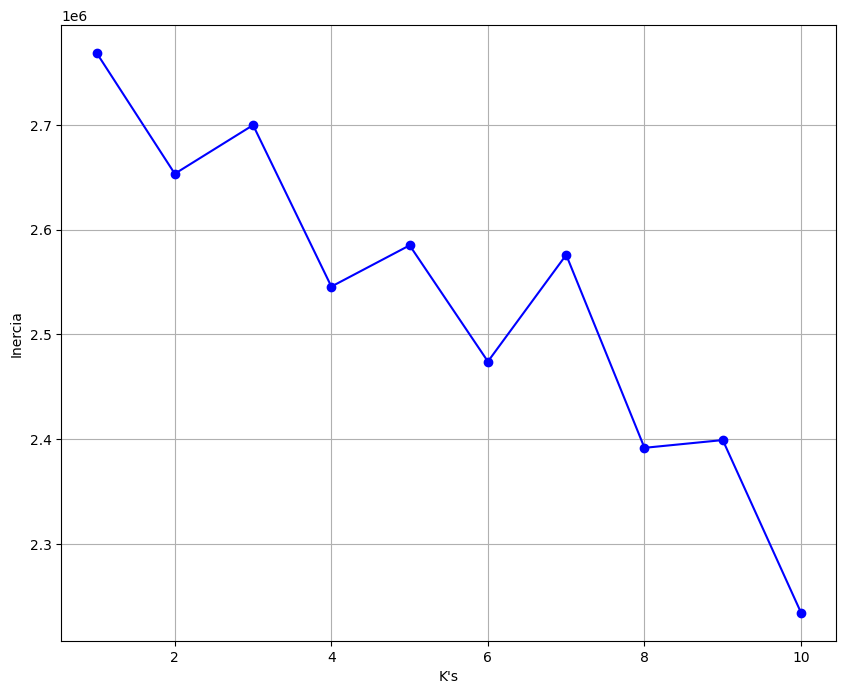

In [142]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(fraud_train["job_clean"])
x_scaler = MaxAbsScaler()
X = x_scaler.fit_transform(X)
inertia = list() 
  
for k in range(1, 11): 
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)    
    
    inertia.append(kmeans.inertia_) 
    
print(inertia)

plt.figure(figsize = (10, 8))

plt.plot(range(1, len(inertia) + 1), inertia, marker = "o", color = "blue")

plt.xlabel("K's") 

plt.ylabel("Inercia") 

plt.grid()

plt.show()

plt.show()

Seleccionamos un numero de clusters aplicando la tecnica del codo, en este caso observamos que 6 es un buen número de clusters

Ahora añadimos una columna llamada cluster a nuestro data set, con el objetivo de clasificar todos los trabajos con el numero de cluster que le ha asignaod el algoritmo, luego los imprimimos para ver en más detalle si ha acertado en base a nuestros criterios

In [147]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(X)

fraud_train['job_cluster'] = kmeans.labels_

for i in range(6):
    print("Cluster ", i)
    
    print(fraud_train[fraud_train['job_cluster'] == i]['job'])

job_cluster_dict = dict(zip(fraud_train['job'], fraud_train['job_cluster']))



Cluster  0
2                                Nature conservation officer
21                                         Probation officer
26                                            Police officer
27                                 Education officer, museum
32               Armed forces training and education officer
                                 ...                        
1296599                                    Fisheries officer
1296613                              Chief Operating Officer
1296620                               Chief Strategy Officer
1296645             Conservation officer, historic buildings
1296658    Historic buildings inspector/conservation officer
Name: job, Length: 110915, dtype: object
Cluster  1
108             Health service manager
149          Building control surveyor
220          Building control surveyor
222        Engineer, building services
259                  Building surveyor
                      ...             
1296310              Building su

In [148]:
fraud_train

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,job_clean,job_cluster
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,psychologist counselling,2
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,special educational need teacher,4
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,nature conservation officer,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,patent attorney,2
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,dance movement psychotherapist,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,geoscientist,2
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,production assistant television,2
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,naval architect,2
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,volunteer coordinator,2
